In [1]:
# In this part the libraries are imported
# Spark structure is setted.
import os
import time
import datetime
import hashlib
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion, OneHotEncoderEstimator, CountVectorizer, Binarizer, StringIndexer, QuantileDiscretizer
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [2]:
spark = SparkSession \
    .builder \
    .config('spark.app.name', 'Denek') \
    .config('spark.jars', '/home/appuser/ojdbc6.jar') \
    .config('spark.master', 'local[*]') \
    .config('spark.driver.memory', '100g') \
    .config('spark.driver.maxResultSize', '100g') \
    .config('spark.executer.memory', '1g') \
    .config('spark.executer.cores', '1000') \
    .config('spark.cores.max', '1000') \
    .config('spark.python.worker.memory', '1g') \
    .config('spark.sql.shuffle.partitions', '1000') \
    .config('spark.sql.broadcastTimeout', '36000') \
    .getOrCreate()
sc = spark.sparkContext

In [20]:
#df = spark.read.format("csv").option("header", "true").load("datasetAll.csv")
df = spark.read.csv('datasetAll.csv', header='true', inferSchema='true')

In [21]:
df.printSchema()

root
 |-- MIM-HourPerBrowsing: double (nullable = true)
 |-- MIM-NumEditEvent: integer (nullable = true)
 |-- MIM-NumRareBrws: double (nullable = true)
 |-- MIM-TimeSpent: double (nullable = true)
 |-- MIM-HourPerEditing: double (nullable = true)
 |-- MIM-NumEditingDevelopers: integer (nullable = true)
 |-- MIM-NumRareEdit: double (nullable = true)
 |-- MIM-TimeSpentAfterEdit: double (nullable = true)
 |-- MIM-MaxTimeIntervalBrwsBrws: double (nullable = true)
 |-- MIM-NumInterruptions: double (nullable = true)
 |-- MIM-NumRepeatedEdit: double (nullable = true)
 |-- MIM-TimeSpentBeforeEdit: double (nullable = true)
 |-- MIM-MaxTimeIntervalBrwsEdit: double (nullable = true)
 |-- MIM-NumParallelBrws: double (nullable = true)
 |-- MIM-NumSelectionEvent: integer (nullable = true)
 |-- MIM-MaxTimeIntervalEditEdit: double (nullable = true)
 |-- MIM-NumParallelEdit: double (nullable = true)
 |-- MIM-TimeSinceLastTask: double (nullable = true)
 |-- MIM-NumMultiTasks: double (nullable = true)
 |

In [22]:
df.select("*").toPandas().head().transpose()

,0,1,2,3,4
MIM-HourPerBrowsing,28.821882,28.459457,395.150632,0.008681,42.999096
MIM-NumEditEvent,97.000000,207.000000,503.000000,3.000000,488.000000
MIM-NumRareBrws,0.006329,0.043478,0.000000,0.000000,0.032051
MIM-TimeSpent,340.090761,372.069971,600.970585,16.967153,201.214293
MIM-HourPerEditing,30.598791,4.285104,384.589949,0.014167,17.916694
...,...,...,...,...,...
HM-AvgOfCodeChurn,-2.139535,-2.777778,0.700000,0.000000,1.875000
HM-NumOfAuthors,3.000000,2.000000,3.000000,1.000000,4.000000
HM-Age,4.000000,104.000000,46.000000,387.000000,75.000000
HM-WeightedAge,51.693779,46.436462,75.728645,166.000000,49.953075


## Summary Statistics

In [23]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
df.describe(numeric_features).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
MIM-HourPerBrowsing,3077,70.65785016249538,243.89191382130255,2.78E-4,7562.35375
MIM-NumEditEvent,3077,55.145271368215795,262.997825708884,0,9674
MIM-NumRareBrws,3077,0.32616039616509535,2.1964266409497593,0.0,40.0
MIM-TimeSpent,3077,286.3162544033142,340.40288321507506,0.0,4565.021389
...,...,...,...,...,...
HM-AvgOfCodeChurn,3077,2.9261295622359436,8.288800842970602,-43.153846,110.625
HM-NumOfAuthors,3077,2.571010724731882,1.6497363698291188,0,12
HM-Age,3077,106.85505362365942,83.14677387502485,0,424
HM-WeightedAge,3077,76.27783309912242,52.01435025014985,0.0,193.0


## Correlations and Data Preparation

In [17]:
sampled_data = df.select(numeric_features).sample(False, 0.05)
print("The sampled dataset contains {} samples.".format(sampled_data.count()))

The sampled dataset contains 146 samples.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

g = sns.pairplot(sampled_data.toPandas(), diag_kind="kde")
g.fig.subplots_adjust(top=0.93, wspace=0.2)
g.fig.suptitle('Bug Attributes Pairwise Plots', fontsize=18, fontweight='bold')

## Using the Spark MLlib Package

In [26]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(df).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(1.0, [28.459457,207.0,0.043478,372.069971,4.285104,4.0,0.0,104.128819,2810.553889,11.322981,6.099379,80.158845,2810.563056,18.857143,160.0,2810.565833,9.018634,811.101111,8.099379,0.79234,10.745342,732.841892,416.400144,327.445168,2.0,6.0,68.0,10.0,0.35,5.0,2.0,1.0,4.0,11.0,32.0,20.0,22.0,43.0,2.0,14.0,5.0,15.0,2.0,21.0,9.0,8.0,8.0,6.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,50.0,18.0,181.0,231.0,51.0,132.0,10.0,12.0,0.0,24.0,-50.0,-2.777778,2.0,104.0,46.436462]), LabeledPoint(1.0, [395.150632,503.0,0.0,600.970585,384.589949,1.0,0.0,473.460556,5084.036667,11.315789,3.631579,0.134872,5084.204444,17.947368,565.0,5084.204722,6.789474,5885.3525,3.421053,0.736879,8.684211,247.238067,155.983594,137.132662,2.0,21.0,1309.0,96.0,0.62,21.0,2.0,1.0,66.0,387.0,612.0,224.0,426.0,793.0,3.0,423.0,21.0,488.0,2.0,225.0,207.0,192.0,189.0,104.0,0.875,0.0,0.875,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,8.0,0.0,0.0,0.0,1.0

In [27]:
print("Feature 1 is the {}.".format(df.columns[1]))

Feature 1 is the MIM-NumEditEvent.


In [29]:
def printAllMetrics(predictionsDF):
  predictionsDF.groupBy('label', 'predictedLabel').count().show()
  print("=*=*=*=*=*=*=*=*=*=*=*=*=*=")
  TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
  FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
  TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
  FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

  precision_p   = TP/(TP+FP)
  precision_n   = TN/(TN+FN)
  recall_p      = TP/(TP+FN)
  recall_n      = TN/(TN+FP)
  f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
  f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
  avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
  avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
  avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
  accuracy      = (TN+TP)/(TP+FN+TN+FP)
 
  print('Precision of True    ', precision_p)
  print('Precision of False   ', precision_n)
  print('** Avg Precision     ', avg_precision)
  print('Recall of True       ', recall_p)
  print('Recall of False      ', recall_n)
  print('** Avg Recall        ', avg_recall)
  print('F1 of True           ', f1_p)
  print('F1 of False          ', f1_n)
  print('** Avg F1            ', avg_f1)
  print('** Accuracy          ', accuracy)

In [30]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
  predictions = model.predict(test_data.map(lambda r: r.features))
  return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
  metrics = MulticlassMetrics(predictions_and_labels)
  print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
  print('Precision of True    ', metrics.precision(1))
  print('Precision of False   ', metrics.precision(0))
  print('Weighted Precision   ', metrics.weightedPrecision)
  print('Recall of True       ', metrics.recall(1))
  print('Recall of False      ', metrics.recall(0))
  print('Weighted Recall      ', metrics.weightedRecall) 
  print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
  print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
  print('Weighted fMeasure    ', metrics.weightedFMeasure())
  print('Accuracy             ', metrics.accuracy)

In [31]:
predictions_and_labels = getPredictionsLabels(model, testing_data).cache()
printMetrics(predictions_and_labels)

Confusion Matrix
 [[483.  18.]
 [ 72.  32.]]
Precision of True     0.64
Precision of False    0.8702702702702703
Weighted Precision    0.8306866205048024
Recall of True        0.3076923076923077
Recall of False       0.9640718562874252
Weighted Recall       0.8512396694214875
FMeasure of True      0.4155844155844156
FMeasure of False     0.9147727272727274
Weighted fMeasure     0.8289618439411829
Accuracy              0.8512396694214877


In [32]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   32|
|  0.0|           1.0|   18|
|  1.0|           0.0|   72|
|  0.0|           0.0|  483|
+-----+--------------+-----+

=*=*=*=*=*=*=*=*=*=*=*=*=*=
Precision of True     0.64
Precision of False    0.8702702702702703
** Avg Precision      0.8306866205048022
Recall of True        0.3076923076923077
Recall of False       0.9640718562874252
** Avg Recall         0.8512396694214877
F1 of True            0.4155844155844156
F1 of False           0.9147727272727274
** Avg F1             0.8289618439411829
** Accuracy           0.8512396694214877


In [33]:
df.groupby('Buggy').count().show()

+-----+-----+
|Buggy|count|
+-----+-----+
|    1|  515|
|    0| 2562|
+-----+-----+



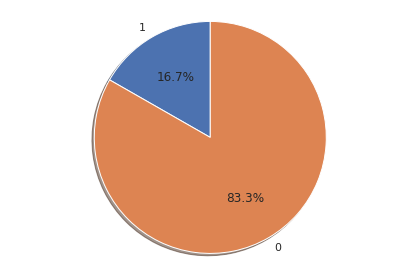

In [34]:
import matplotlib.pyplot as plt
# Pie chart
labels = df.groupby('Buggy').count().toPandas().Buggy.tolist()
sizes = df.groupby('Buggy').count().toPandas()["count"].tolist()
explode = (0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

## Stratified Sampling

In [35]:
stratified_data = df.sampleBy('Buggy', fractions={0: df.select("Buggy").where('Buggy == 1').count()/ df.select("Buggy").where('Buggy == 0').count(), 1: 1.0}, seed = 5323)
stratified_data.groupby('Buggy').count().show()

+-----+-----+
|Buggy|count|
+-----+-----+
|    1|  515|
|    0|  518|
+-----+-----+



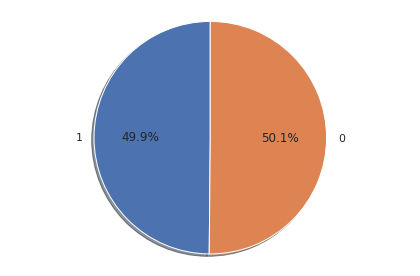

In [36]:
labels = stratified_data.groupby('Buggy').count().toPandas().Buggy.tolist()
sizes = stratified_data.groupby('Buggy').count().toPandas()["count"].tolist()
explode = (0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [37]:
training_data, testing_data = labelData(stratified_data).randomSplit([0.8, 0.2])
model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2, categoricalFeaturesInfo={}, impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data).cache()
printMetrics(predictions_and_labels)
print("========================================")
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

Confusion Matrix
 [[44. 57.]
 [33. 75.]]
Precision of True     0.5681818181818182
Precision of False    0.5714285714285714
Weighted Precision    0.56975082333934
Recall of True        0.6944444444444444
Recall of False       0.43564356435643564
Weighted Recall       0.569377990430622
FMeasure of True      0.625
FMeasure of False     0.49438202247191015
Weighted fMeasure     0.5618783936347509
Accuracy              0.569377990430622
+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   75|
|  0.0|           1.0|   57|
|  1.0|           0.0|   33|
|  0.0|           0.0|   44|
+-----+--------------+-----+

=*=*=*=*=*=*=*=*=*=*=*=*=*=
Precision of True     0.5681818181818182
Precision of False    0.5714285714285714
** Avg Precision      0.56975082333934
Recall of True        0.6944444444444444
Recall of False       0.43564356435643564
** Avg Recall         0.569377990430622
F1 of True            0.625
F1 of False           0.4943820

## Using the Spark ML Package

In [40]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
  # Combining a given list of columns into a single vector column features
  assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
  # Index labels, adding metadata to the label column
  indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')
  # Automatically identify categorical features and index them
  featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)
  pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])
  model = pipeline.fit(df)
  data = model.transform(df)
  data = data.withColumn('label', F.col(labelCol))
  return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

In [43]:
numericCols = stratified_data.columns
numericCols.remove("Buggy")

vectorized_data = get_dummy(df, numericCols, "Buggy")
vectorized_stratified_data = get_dummy(stratified_data, numericCols, "Buggy")

In [44]:
vectorized_stratified_data.show(2, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## K-fold cross validation

In [48]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
  names = []
  underROC_train = []
  # underROC_test = []
  f1_train = []
  # f1_test = []
  wp_train = []
  # wp_test = []
  wr_train = []
  # wr_test = []
  acc_train = []
  # acc_test = []

  evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")
  evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
  evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
  evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
  evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

  for name, clf in classifiers:
    cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
    cvModel = cv.fit(vectorized_train_data)  
    predict_train = cvModel.transform(vectorized_train_data)
    # predict_test = cvModel.transform(vectorized_test_data)
    underROC_train.append(evaluatorB.evaluate(predict_train))
    # underROC_test.append(evaluatorB.evaluate(predict_test))
    f1_train.append(evaluatoracc.evaluate(predict_train))
    # f1_test.append(evaluatoracc.evaluate(predict_test))
    wp_train.append(evaluatorwp.evaluate(predict_train))
    # wp_test.append(evaluatorwp.evaluate(predict_test))
    wr_train.append(evaluatorwr.evaluate(predict_train))
    # wr_test.append(evaluatorwr.evaluate(predict_test))
    acc_train.append(evaluatoracc.evaluate(predict_train))
    # acc_test.append(evaluatoracc.evaluate(predict_test))
    names.append(name)

  #cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test), schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])
  cvResults = spark.createDataFrame(zip(names, underROC_train, acc_train, f1_train, wp_train, wr_train), schema=['Classifier name', 'underROC_train','Accuracy_train', 'f1_train','wPrecision_train', 'wRecall_train'])
  for t in cvResults.dtypes:
    if t[1] == 'double':
      cvResults = cvResults.withColumn(t[0], F.round(cvResults[t[0]], roundLevel))
  
  return cvResults

In [49]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()
classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
#classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures'))) # Naive Bayes requires nonnegative feature values but found
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('GBT', GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################

cvResults_data = cvComparing(vectorized_train_data = vectorized_data, vectorized_test_data = '', classifiers = classifiers, paramGrid = paramGrid, numFolds = 5, roundLevel = 3, seed = 123)
cvResults_stratified_data = cvComparing(vectorized_train_data = vectorized_stratified_data, vectorized_test_data = '', classifiers = classifiers, paramGrid = paramGrid, numFolds = 5, roundLevel = 3, seed = 123)


                      0      1      2      3      4
Classifier name      LR    SVC     DT     RF    GBT
underROC_train    0.565  0.508  0.734  0.689  0.843
Accuracy_train    0.837  0.835  0.887  0.882  0.935
f1_train          0.837  0.835  0.887  0.882  0.935
wPrecision_train    0.8  0.844  0.878  0.874  0.933
wRecall_train     0.837  0.835  0.887  0.882  0.935


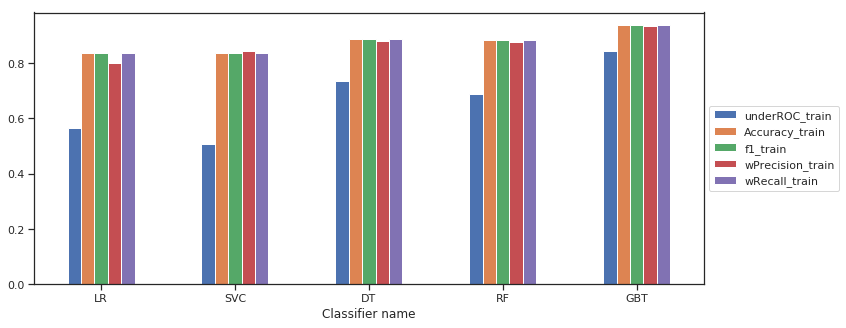

In [51]:
print(cvResults_data.toPandas().transpose())
cvResults_data_df = cvResults_data.toPandas().set_index('Classifier name')

ax = cvResults_data_df.plot.bar(rot=0, figsize=(12,5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                      0      1      2      3      4
Classifier name      LR    SVC     DT     RF    GBT
underROC_train    0.744  0.763  0.847  0.844  0.971
Accuracy_train    0.744  0.763  0.847  0.844  0.971
f1_train          0.744  0.763  0.847  0.844  0.971
wPrecision_train  0.744  0.763  0.847  0.847  0.971
wRecall_train     0.744  0.763  0.847  0.844  0.971


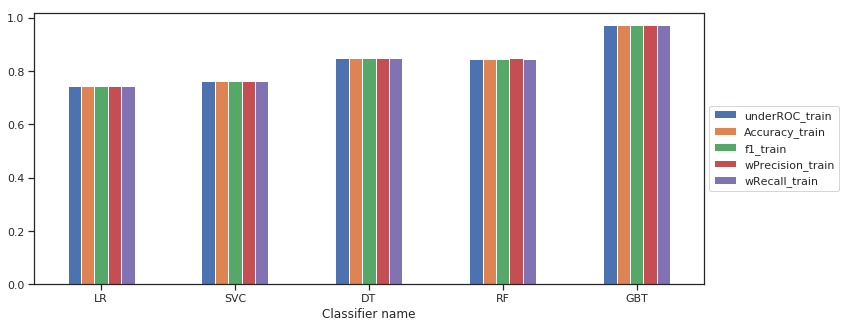

In [52]:
print(cvResults_stratified_data.toPandas().transpose())
cvResults_stratified_data_df = cvResults_stratified_data.toPandas().set_index('Classifier name')

ax = cvResults_stratified_data_df.plot.bar(rot=0, figsize=(12,5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [62]:
def val_to_list(val):
    """
    Convert a single value string or number to a list
    :param val:
    :return:
    """
    if val is not None:
        if not isinstance(val, list):
            val = [val]

    return val


def one_list_to_val(val):
    """
    Convert a single list element to val
    :param val:
    :return:
    """
    if isinstance(val, list) and len(val) == 1:
        result = val[0]
    else:
        result = val

    return result

def name_col(col_names: str, append: str) -> str:
    """
    Whenever you want to name and output user this function. This ensure that we manage and Standard when naming
    :param col_names: Column name
    :param append: string to be appended
    :return:
    """
    separator = "***"
    append = str(append)
    col_names = val_to_list(col_names)
    if len(col_names) > 1:
        output_col = ('_'.join(str(elem) for elem in col_names))[:10] + separator
    else:
        output_col = one_list_to_val(col_names)

    return output_col + separator + append.upper()

In [71]:
def get_OneHot(df, numericCols, labelCol):
    inputCols = []
    for col_name in numericCols:
        col_in = name_col(col_name, "in")
        col_out = name_col(col_name, "out")
        discretizer = QuantileDiscretizer(numBuckets=5, inputCol=col_name, outputCol=col_in, handleInvalid="skip")
        pyencoder = OneHotEncoderEstimator(inputCols=[col_in], outputCols=[col_out], dropLast=False)
        stages = [discretizer, pyencoder]
        pipeline = Pipeline(stages=stages)
        df = pipeline.fit(df).transform(df)
        inputCols.append(col_out)
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=inputCols, outputCol="features")
    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')
    pipeline = Pipeline(stages = [assembler] + [indexer])
    model = pipeline.fit(df)
    data = model.transform(df)
    return data.select('features','indexedLabel')

In [72]:
vectorized_data = get_OneHot(df, numericCols, "Buggy")

In [73]:
vectorized_data.show(2)

+--------------------+------------+
|            features|indexedLabel|
+--------------------+------------+
|(351,[3,9,11,15,2...|         0.0|
|(351,[3,9,11,15,1...|         1.0|
+--------------------+------------+
only showing top 2 rows



In [75]:
denek = vectorized_data.withColumnRenamed("features","indexedFeatures")
onehotResults = cvComparing(vectorized_train_data = denek, vectorized_test_data = '', classifiers = classifiers, paramGrid = paramGrid, numFolds = 5, roundLevel = 3, seed = 123)

                      0      1      2      3      4
Classifier name      LR    SVC     DT     RF    GBT
underROC_train    0.738  0.668  0.707  0.548  0.785
Accuracy_train    0.884  0.862  0.882  0.847  0.919
f1_train          0.884  0.862  0.882  0.847  0.919
wPrecision_train  0.875  0.845  0.872  0.852  0.918
wRecall_train     0.884  0.862  0.882  0.847  0.919


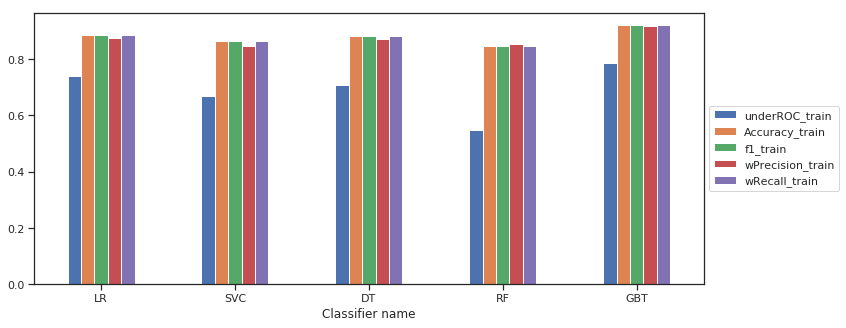

In [76]:
print(onehotResults.toPandas().transpose())
onehotResults_df = onehotResults.toPandas().set_index('Classifier name')

ax = onehotResults_df.plot.bar(rot=0, figsize=(12,5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [77]:
# Degree with two
polynomialexpansion = PolynomialExpansion(degree = 2, inputCol="features", outputCol="indexedFeatures")
record = polynomialexpansion.transform(vectorized_data)
record = record.drop("features")

In [78]:
record.show(5)

+------------+--------------------+
|indexedLabel|     indexedFeatures|
+------------+--------------------+
|         0.0|(62127,[9,13,54,5...|
|         1.0|(62127,[9,13,54,5...|
|         1.0|(62127,[14,19,54,...|
|         0.0|(62127,[0,1,35,36...|
|         1.0|(62127,[9,13,54,5...|
+------------+--------------------+
only showing top 5 rows



In [79]:
polynomialResults = cvComparing(vectorized_train_data = record, vectorized_test_data = '', classifiers = classifiers, paramGrid = paramGrid, numFolds = 3, roundLevel = 3, seed = 123)

                   0    1      2      3      4
Classifier name   LR  SVC     DT     RF    GBT
underROC_train     1    1  0.721   0.66  0.852
Accuracy_train     1    1  0.895  0.883  0.945
f1_train           1    1  0.895  0.883  0.945
wPrecision_train   1    1  0.891  0.889  0.946
wRecall_train      1    1  0.895  0.883  0.945


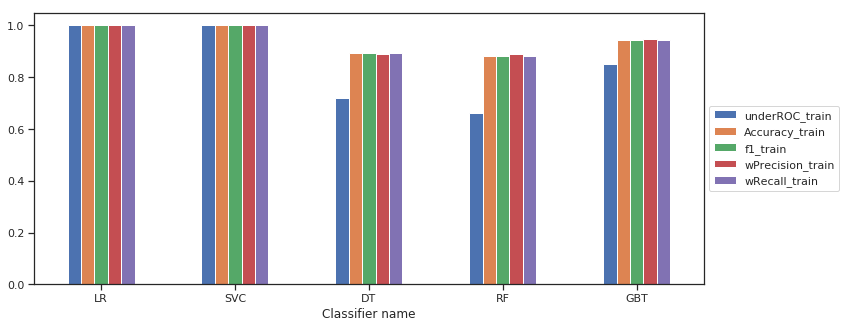

In [80]:
print(polynomialResults.toPandas().transpose())
polynomialResults_df = polynomialResults.toPandas().set_index('Classifier name')

ax = polynomialResults_df.plot.bar(rot=0, figsize=(12,5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [86]:
class Evaluation(object):
    def __init__(self, y, scores):
        self.y = y
        self.scores = scores
    
    def plot_roc_curve(self):
        auc_score = metrics.roc_auc_score(self.y, self.scores)
        fpr, tpr, thresholds = metrics.roc_curve(self.y, self.scores)
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, linewidth=3, label='Eğri Altındaki Alan: {:.2f}'.format(auc_score))
        plt.axis([0,1,0,1])
        plt.xlabel('Yalancı Pozitif Oranı', fontsize=15)
        plt.ylabel('Gerçek Pozitif Oranı', fontsize=15)
        plt.legend()
        plt.title('Alıcı İşletim Karakteristiği', fontsize=20)
        plt.tight_layout()
        #plt.savefig("Images/ROC.png", transparent=True)
        plt.show()
        
    def plot_precision_recall_f1(self):
        precisions, recalls, thresholds = metrics.precision_recall_curve(self.y, self.scores)
        threshold_array = np.arange(1,100)/100
        f1_array = np.zeros(len(threshold_array))
        for i in range(len(threshold_array)):
            threshold = threshold_array[i]
            prediction = (self.scores > threshold).astype(int)
            f1 = metrics.f1_score(self.y, prediction)
            f1_array[i] = f1  
        plt.figure(figsize=(12,5))
        plt.rcParams['axes.linewidth'] = 2
        plt.plot(thresholds, precisions[:-1] , linewidth=3, label="Duyarlılık")
        plt.plot(thresholds, recalls[:-1],  linewidth=3, label="Doğruluk")
        plt.plot(threshold_array, f1_array, linewidth=3,label='$F_1$ Skoru')
        plt.xlabel('Eşik Değeri', fontsize=20)
        plt.ylabel('Skor', fontsize=20)
        plt.title('Duyarlılık Doğruluk ve $F_1$ Skoru Eğrileri', fontsize=20)
        plt.legend()
        plt.tight_layout()
        #plt.savefig("Images/precision-recall_new.png", transparent=True)
        plt.show()
        
    def plot_confusion(self, threshold):
        prediction = (self.scores > threshold).astype(int)
        conf = metrics.confusion_matrix(self.y, prediction)
        precision = metrics.precision_score(self.y, prediction)
        recall = metrics.recall_score(self.y, prediction)
        f1 = metrics.f1_score(self.y, prediction)
        norm = np.sum(conf, axis = 0).reshape(1,2)
        print ("Precision Score:\n", precision)
        print ("Recall Score:\n", recall)
        print ("F1 Score:\n", f1)
        print ("Confusion Matrix:\n", conf)

        truth = ['REAL NOT BUGGY', 'REAL BUGGY']
        observations = ['PREDICTED NOT BUGGY', 'PREDICTED BUGGY']
        plt.rcParams['figure.figsize'] = 5, 5
        fig, ax = plt.subplots()
        im, cbar = heatmap(conf, truth, observations, ax=ax,
                           cmap="Purples", cbarlabel="prediction")
        texts = annotate_heatmap(im, valfmt="{x:.0f}")
        fig.tight_layout()
        plt.show()

In [93]:
## Some Useful Functions for Visualisation
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    #ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[1 if im.norm(data[i, j]) > threshold else 0])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts

## Explainability

In [85]:
# %80 Train, %20 Test
train, test = record.randomSplit([.8, .2], seed=1234)
# LR Model
lr = LogisticRegression(
     labelCol="indexedLabel",
     tol=1e-7,
     elasticNetParam=1,
     regParam=0.,
     featuresCol="indexedFeatures",
     maxIter=200,
     threshold=0.2
)

model = lr.fit(train)
# model.write().overwrite().save(storage_folder+"/model")
result = model.transform(test)

## Collect Parameters

In [88]:
feature_weights = model.coefficients.toArray()
raw_prediction = np.array(model.transform(train).select('rawPrediction').collect())[:,0,0]
mean = np.mean(raw_prediction)
stddev = np.std(raw_prediction)
#########
label = np.array(result.select('indexedLabel').collect())[:,0]
probability = np.array(result.select('probability').collect())
bug_probability = probability[:,0,1]
probability = probability[:,0,0]
raw_prediction = np.array(result.select('rawPrediction').collect())
bug_raw_prediction = raw_prediction[:,0,1]
raw_prediction = raw_prediction[:,0,0]

In [89]:
import warnings
warnings.filterwarnings('ignore')
label = label.astype(np.float)

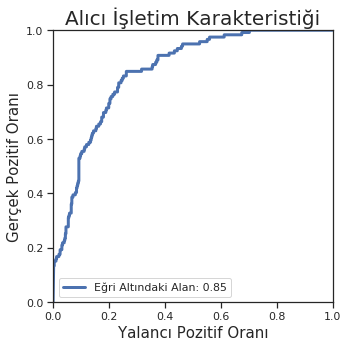

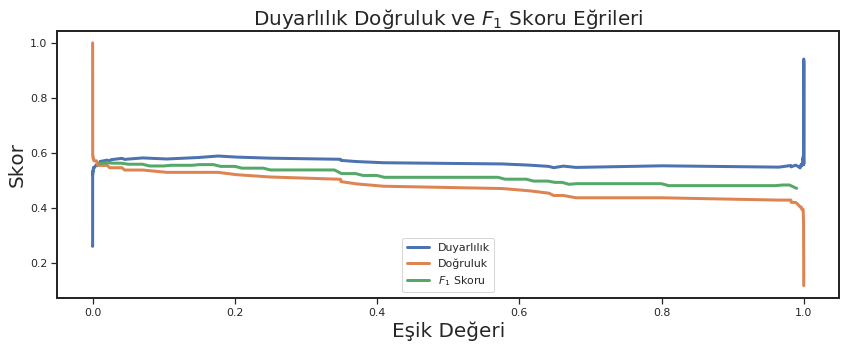

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

evaluate = Evaluation(label, bug_probability)
evaluate.plot_roc_curve()
evaluate.plot_precision_recall_f1()

Precision Score:
 0.56
Recall Score:
 0.47058823529411764
F1 Score:
 0.5114155251141552
Confusion Matrix:
 [[433  44]
 [ 63  56]]


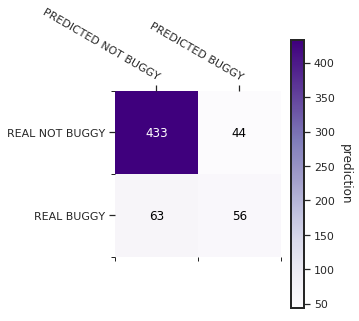

In [94]:
evaluate.plot_confusion(0.5)

## Score

In [95]:
def score_transformer(x):
    a = (x - mean) / stddev
    return 100 * (1/(1 + np.exp(-a)))

def sigmoid(x):
    return (1/(1 + np.exp(-x)))

scores = score_transformer(raw_prediction)

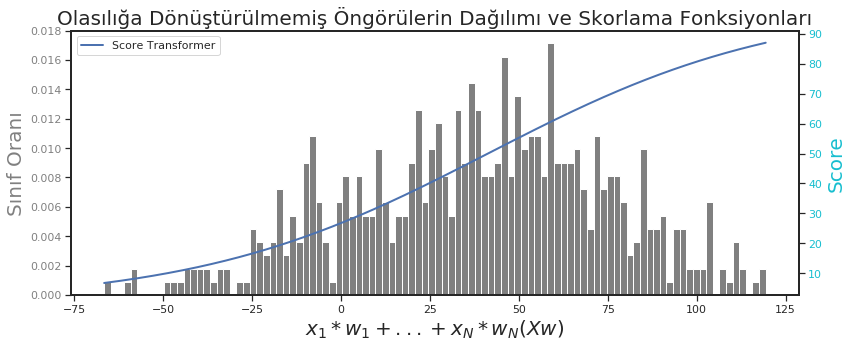

In [100]:
x = np.linspace(np.min(raw_prediction), np.max(raw_prediction), 10000)
fig, ax1 = plt.subplots(figsize=(12,5))
plt.title("Olasılığa Dönüştürülmemiş Öngörülerin Dağılımı ve Skorlama Fonksiyonları", fontsize=20)
color = 'grey'
ax1.set_xlabel("$x_1*w_1 + ... + x_N*w_N (Xw)$", fontsize=20)
ax1.set_ylabel('Sınıf Oranı', color=color, fontsize=20)
ax1.hist(raw_prediction,color=color,bins=100, density=True)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Score', color=color,  fontsize=20)  # we already handled the x-label with ax1
ax2.plot(x, score_transformer(x), linewidth=2, label="Score Transformer")
ax2.legend()
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("Images/histogram_raw_pred.png", transparent=True)
plt.show()


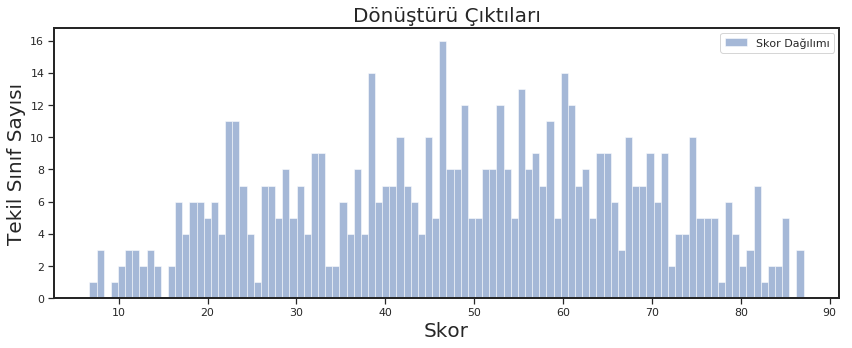

In [101]:
plt.figure(figsize=(12,5))
plt.title("Dönüştürü Çıktıları", fontsize=20)
plt.hist(scores, bins=100, alpha=0.5, label="Skor Dağılımı")
plt.xlabel("Skor", fontsize=20)
plt.ylabel("Tekil Sınıf Sayısı", fontsize=20)
plt.legend()
plt.tight_layout()
#plt.savefig("Images/dagilim.png", transparent=True)
plt.show()

## Önemli Özniteliklerin Belirlenmesi

In [102]:
filteredResult = result.limit(5)
filteredResult.show()

+------------+--------------------+--------------------+--------------------+----------+
|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|
+------------+--------------------+--------------------+--------------------+----------+
|         0.0|(62127,[0,1,20,21...|[-18.889365837758...|[6.2582462426416E...|       1.0|
|         0.0|(62127,[0,1,20,21...|[-5.9250702672364...|[0.00266450141610...|       1.0|
|         0.0|(62127,[0,1,20,21...|[50.3833066198429...|[1.0,1.3146433682...|       0.0|
|         0.0|(62127,[0,1,27,28...|[98.3516216027849...|[1.0,1.9338974986...|       0.0|
|         0.0|(62127,[0,1,27,28...|[35.0641806740150...|[0.99999999999999...|       0.0|
+------------+--------------------+--------------------+--------------------+----------+



In [108]:
# get features
collectedFeatures = np.array(filteredResult.select('indexedFeatures').collect())[0,0,:]
collectedRawPrediction = np.array(filteredResult.select('rawPrediction').collect())[:,0,0]
featureIndex = np.where(collectedFeatures == 1.0)
# Filter weights for m_no
filtered_score = score_transformer(collectedRawPrediction)
filtered_weights = feature_weights[featureIndex]
vocabulary_array = np.array(feature_vocabulary)
filtered_features = vocabulary_array[featureIndex]
# Sort weights
sort_filtered = filtered_weights.argsort()
sorted_filtered_weights = filtered_weights[sort_filtered]
top5Weights = np.concatenate([sorted_filtered_weights[-5:], sorted_filtered_weights[:5]])
# Sort features
sorted_filtered_features = filtered_features[sort_filtered].tolist()
top5Features = np.concatenate([sorted_filtered_features[-5:], sorted_filtered_features[:5]])
print(top5Weights)
print(top5Features)

[ 0.69681597  0.7365067   0.92664172  0.97865793  1.10401221 -1.63102339
 -0.77460687 -0.52019325 -0.50336027 -0.46407152]
['MIM-NumEditEvent_-inf_1.0 * MIM-NumRepeatedBrws_12.75_17.0'
 'MIM-NumEditEvent_-inf_1.0 * MIM-TimeSinceLastTask_10044.14389_inf'
 'MIM-NumEditEvent_-inf_1.0 * MIM-TimeSpentAfterEdit_-inf_0.356111'
 'MIM-NumEditEvent_-inf_1.0 * MIM-NumParallelBrws_57.4_inf'
 'MIM-HourPerBrowsing_-inf_0.127407 * MIM-NumEditEvent_-inf_1.0'
 'MIM-NumEditEvent_-inf_1.0 * MIM-NumInterruptions_5.0_8.636364'
 'MIM-NumRepeatedEdit_3.111111_5.0 * MIM-NumRepeatedBrws_12.75_17.0'
 'CM-MaxCyclomaticModified_2.0_3.0 * HM-Age_174.0_inf'
 'CM-MaxCyclomaticModified_2.0_3.0 * HM-WeightedAge_125.5_inf'
 'MIM-NumParallelEdit_8.297872_11.033898 * CM-CountLineComment_27.0_49.0']


In [104]:
def get_OneHotVocab(df, numericCols, labelCol):
    inputCols = []
    feature_vocabulary = []
    for col_name in numericCols:
        col_in = name_col(col_name, "in")
        col_out = name_col(col_name, "out")
        discretizer = QuantileDiscretizer(numBuckets=5, inputCol=col_name, outputCol=col_in, handleInvalid="skip")
        pyencoder = OneHotEncoderEstimator(inputCols=[col_in], outputCols=[col_out], dropLast=False)
        stages = [discretizer, pyencoder]
        pipeline = Pipeline(stages=stages)
        model = pipeline.fit(df)
        #model.write().overwrite().save(storage_folder + '{}_QuantileDiscretizer'.format(col_name))
        df = model.transform(df)
        inputCols.append(col_out)
        l = model.stages[0].getSplits()
        vocabulary = [col_name + "_" + str(l[x]) + "_" + str(l[x + 1]) for x in range(len(l) - 1)]
        feature_vocabulary += vocabulary
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=inputCols, outputCol="features")
    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')
    pipeline = Pipeline(stages = [assembler] + [indexer])
    model = pipeline.fit(df)
    data = model.transform(df)
    data = data.select('features','indexedLabel')
    return data, feature_vocabulary

In [105]:
vectorized_data2, vocabulary = get_OneHotVocab(df, numericCols, "Buggy")

In [106]:
feature_vocabulary = []
for item1 in vocabulary:
    feature_vocabulary.append(item1)
    for item2 in vocabulary[:vocabulary.index(item1) + 1]:
        feature_vocabulary.append(item2 + " * " + item1)